# Predicción de Riesgo Crediticio con XGBoost

In [3]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 
import multiprocessing
import random




from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
import timeit

## Dataset

Leamos el dataset a utilizar.

In [27]:
# Load the dataset 
X = pd.read_csv("/Users/galovalle/Desktop/DP3/merging.csv", sep=',', decimal=';')
X.shape

(19281, 51)

El dataset consta de:

- 19281 **filas** o instancias
- 51 **columnas** o variables.

Veamos su contenido.

## Pre-procesado

### One-Hot Encoding

Seleccionemos las variables categóricas en primer lugar.

In [28]:
categorical_vars = set(['month_approved_loan'])
numerical_vars = set(X.columns) - categorical_vars
categorical_vars = list(categorical_vars)
numerical_vars = list(numerical_vars)

In [29]:
print(categorical_vars)
print(numerical_vars)

['month_approved_loan']
['bank_name_client_Unity Bank', 'bank_name_client_Unknown', 'loanamount', 'level_of_education_clients_Graduate', 'bank_name_client_Skye Bank', 'bank_name_client_Keystone Bank', 'TipoInteres', 'employment_status_client_Permanent', 'bank_branch_clients', 'bank_name_client_Union Bank', 'bank_name_client_Zenith Bank', 'totaldue', 'realage', 'bank_account_Savings', 'systemloanid', 'termdays', 'bank_name_client_Standard Chartered', 'employment_status_client_Retired', 'exceeds_loan_term_days', 'bank_name_client_EcoBank', 'is_late_for_firstpay', 'bank_name_client_First Bank', 'bank_name_client_Stanbic IBTC', 'good_bad_flag', 'bank_account_Other', 'employment_status_client_Contract', 'employment_status_client_Self-Employed', 'level_of_education_clients_Unknown', 'Unnamed: 0', 'bank_account_Current', 'bank_name_client_Heritage Bank', 'employment_status_client_Unknown', 'bank_account_Unknown', 'bank_name_client_Fidelity Bank', 'bank_name_client_Sterling Bank', 'bank_name_c

Realizamos one hot encoding de las variables categoricas

In [30]:
ohe = OneHotEncoder(sparse = False)
ohe_fit = ohe.fit(X[categorical_vars])
X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe.columns = pd.DataFrame(ohe_fit.get_feature_names())


/Users/galovalle/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Visualizamos los datos iniciales y los que están con one hot encoding para ver la diferencia

In [31]:
X[categorical_vars].head()

,month_approved_loan
0,August
1,April
2,March
3,June
4,June


In [32]:
X_ohe.head()

,"(x0_April,)","(x0_August,)","(x0_December,)","(x0_February,)","(x0_January,)","(x0_July,)","(x0_June,)","(x0_March,)","(x0_May,)","(x0_November,)","(x0_October,)","(x0_September,)","(x0_nan,)"
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Volvemos a pegar las variables numéricas.

In [33]:
X = pd.concat((X_ohe, X[numerical_vars].reset_index()), axis=1)

### Tipificar

Ahora vamos a tipificar los datos, es decir, llevarlos a media 0 y desviación estándar 1.

In [34]:
y = X['good_bad_flag']
del X['good_bad_flag']

In [35]:
X= X.drop(['customerid'],axis=1)

In [36]:
X_scale = pd.DataFrame(scale(X))
X_scale.columns = X.columns
X = X_scale
X.columns = X_scale.columns
print(X.head())

   (x0_April,)  (x0_August,)  (x0_December,)  (x0_February,)  (x0_January,)  \
0    -0.371292      5.463479       -0.226767       -0.258192      -0.240712   
1     2.693298     -0.183034       -0.226767       -0.258192      -0.240712   
2    -0.371292     -0.183034       -0.226767       -0.258192      -0.240712   
3    -0.371292     -0.183034       -0.226767       -0.258192      -0.240712   
4    -0.371292     -0.183034       -0.226767       -0.258192      -0.240712   

   (x0_July,)  (x0_June,)  (x0_March,)  (x0_May,)  (x0_November,)  ...  \
0   -0.191491   -0.525237    -0.322066  -0.456824       -0.221019  ...   
1   -0.191491   -0.525237    -0.322066  -0.456824       -0.221019  ...   
2   -0.191491   -0.525237     3.104952  -0.456824       -0.221019  ...   
3   -0.191491    1.903904    -0.322066  -0.456824       -0.221019  ...   
4   -0.191491    1.903904    -0.322066  -0.456824       -0.221019  ...   

   referred  level_of_education_clients_Post-Graduate  \
0 -0.237317            

/Users/galovalle/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


### Split en Train/Validación/Test

Utilizaremos a modo de ejemplo los ratios habitualmente recomendados:

• Train: 70%.

• Validación: 15%.

• Test: 15%.


In [37]:
perc_values = [0.7, 0.15, 0.15];

Creamos los conjuntos de train, validacion y test con el tamaño seleccionado pero respetando el eje temporal.

In [38]:
# dimensiones de los conjuntos de train y test
n_train = int(X.shape[0] * perc_values[0])
n_val = int(X.shape[0] * perc_values[1])
n_test = int(X.shape[0] * perc_values[2])

# selección del conjunto de train
X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

# selección del conjunto de validación
X_val = X.iloc[(n_train):(n_train+n_val)]
y_val = y.iloc[(n_train):(n_train+n_val)]

# selección del conjunto de test
X_test = X.iloc[(n_train+n_val):]
y_test = y.iloc[(n_train+n_val):]

Visualizamos el tamaño de los 3 subdatasets

In [39]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))
print('Test data size = ' + str(X_test.shape))
print('Test target size = ' + str(y_test.shape))

Train data size = (13496, 62)
Train target size = (13496,)
Validation data size = (2892, 62)
Validation target size = (2892,)
Test data size = (2893, 62)
Test target size = (2893,)



## XGBoost

Vamos a aplicar ahora un modelo de XGBoost para intentar predecir la probabilidad de riesgo crediticio en función de las variables que disponemos en el dataset. Recordemos que la definición de Gradient Boosting es la siguiente:

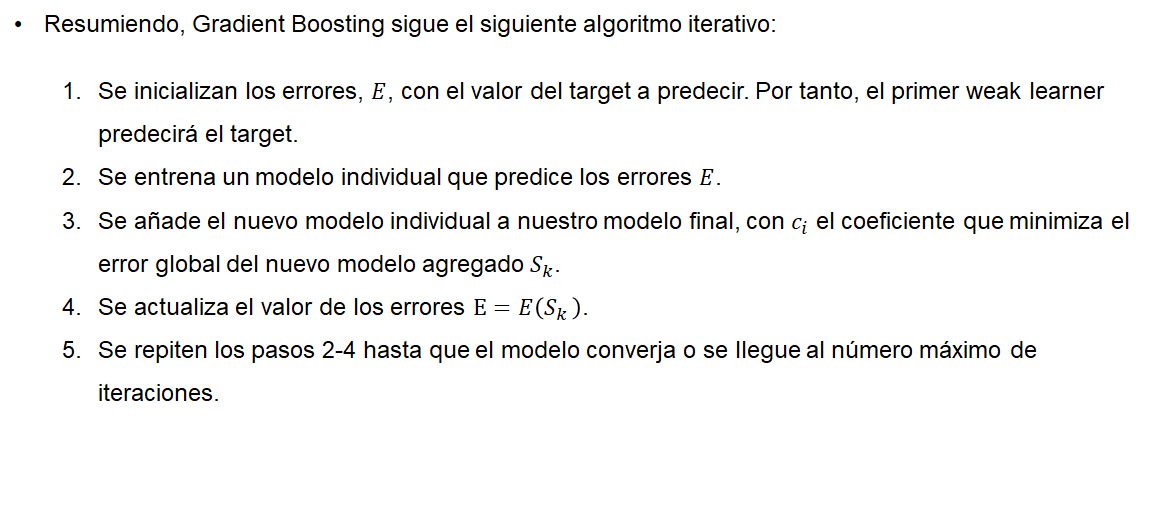


1) Importar modelo.

En este caso tenemos que irnos fuera de scikit-learn para aplicar modelos XGBoost.


In [40]:
from xgboost import XGBClassifier

2) Importar métrica.

In [41]:
from sklearn.metrics import roc_auc_score as auc

3) Definir el método.

Vamos a entrenar un modelo con parámetros por defecto

In [42]:
model = XGBClassifier(random_state = 1)

4) Llamar al método fit para entrenar el modelo. **Utilizaremos early stopping**

In [43]:
model.fit(X_train, 
          np.array(y_train), 
          eval_metric = "auc", 
          eval_set=[(X_val, y_val)],
          early_stopping_rounds = 10,
          verbose=True)

[0]	validation_0-auc:0.59918
[1]	validation_0-auc:0.59401
[2]	validation_0-auc:0.62087
[3]	validation_0-auc:0.62671
[4]	validation_0-auc:0.60751
[5]	validation_0-auc:0.61463
[6]	validation_0-auc:0.60554
[7]	validation_0-auc:0.61872


/Users/galovalle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/galovalle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-auc:0.62065
[9]	validation_0-auc:0.62524
[10]	validation_0-auc:0.62808
[11]	validation_0-auc:0.63065
[12]	validation_0-auc:0.63428
[13]	validation_0-auc:0.63845
[14]	validation_0-auc:0.64744
[15]	validation_0-auc:0.64908
[16]	validation_0-auc:0.64908
[17]	validation_0-auc:0.64908
[18]	validation_0-auc:0.65854
[19]	validation_0-auc:0.66365
[20]	validation_0-auc:0.66742
[21]	validation_0-auc:0.66468
[22]	validation_0-auc:0.65828
[23]	validation_0-auc:0.65605
[24]	validation_0-auc:0.65198
[25]	validation_0-auc:0.65845
[26]	validation_0-auc:0.65638
[27]	validation_0-auc:0.65235
[28]	validation_0-auc:0.65235
[29]	validation_0-auc:0.65147


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

5) Llamar al método predict para generar las predicciones.

In [44]:
pred_train_p = model.predict_proba(X_train)
pred_val_p = model.predict_proba(X_val)
pred_test_p = model.predict_proba(X_test) 

6) Calcular métrica usando las predicciones obtenidas en el paso anterior.

In [45]:
# Calcular métricas de evaluación
auc_train = auc(y_train, pred_train_p[:,1]);
auc_val = auc(y_val, pred_val_p[:,1]);
auc_test = auc(y_test, pred_test_p[:,1]);
results = pd.DataFrame()
results = results.append(pd.DataFrame(data={'model':['XGBoost (Default)'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_4405/934495496.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(data={'model':['XGBoost (Default)'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)


In [46]:
results

,model,auc_train,auc_val,auc_test
0,XGBoost (Default),0.963739,0.66742,0.78521


Vamos a comprobar si XGBoost devuelve probabilidades calibradas.

In [47]:
from sklearn.calibration import calibration_curve


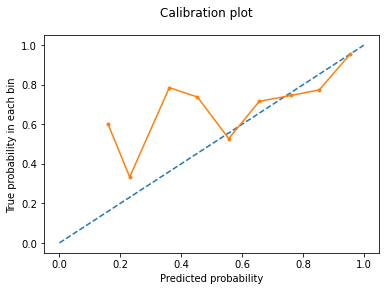

In [48]:
# reliability diagram
fop, mpv = calibration_curve(y_test, pred_test_p[:, 1], n_bins=10)
no_zeros = fop > 0
fop = fop[no_zeros]
mpv = mpv[no_zeros]
no_zeros = mpv > 0
fop = fop[no_zeros]
mpv = mpv[no_zeros]

fig, ax = plt.subplots()
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')

fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.show()

También se puede medir con el brier score.

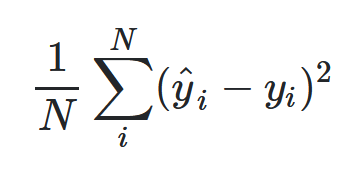

Donde:

- $y_i$ es el target a predecir (0 o 1).
- $\hat{y}_i$ es la probabilidad predicha de pertenecer a la clase 1, $P(y_i = 1)$.

In [26]:
from sklearn.metrics import brier_score_loss

In [27]:
?brier_score_loss

In [28]:
brier_score_loss(y_test, pred_test_p[:, 1])

0.10275857255218052

Las probabilidades parecen calibradas, sino lo están podemos usar:

In [29]:
?CalibratedClassifierCV

Object `CalibratedClassifierCV` not found.


Atentos al comentario sobre **cv = "prefit"**.

# Grid Search


Vamos a proceder a calcular los parámetros óptimos para nuestro modelo. En nuestro caso queremos optimizar todos los hiperparámetros que hemos visto en clase:

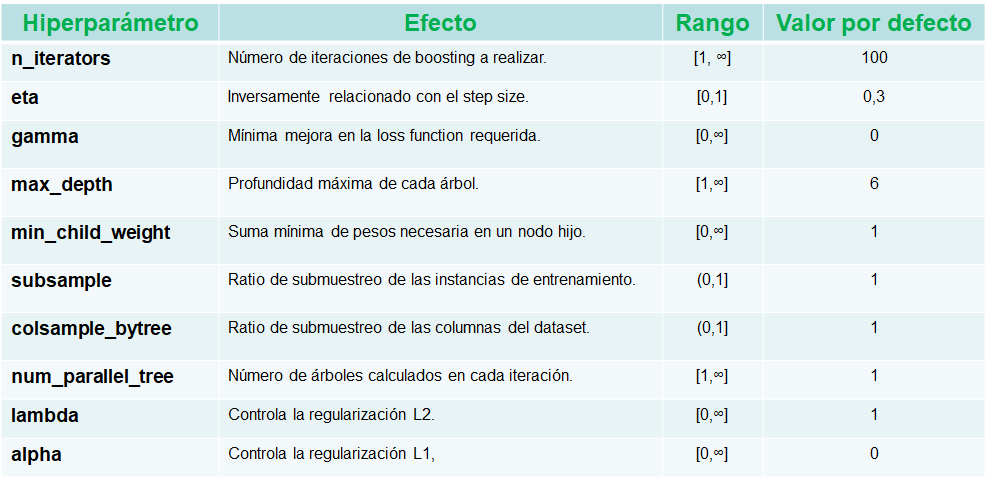

Para establecer nthread detectaremos automáticamente el número de CPUs en nuestro sistema y dejaremos uno libre. Para ello usaremos la función multiprocessing.cpu_count()

In [30]:
help(multiprocessing.cpu_count)

Help on method cpu_count in module multiprocessing.context:

cpu_count() method of multiprocessing.context.DefaultContext instance
    Returns the number of CPUs in the system



In [31]:
nthread = multiprocessing.cpu_count() - 1;
print(nthread);

7


Podemos ayudar a nuestro modelo XGBoost indicando el ratio entre casos negativos y positivos.

In [32]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
print(scale_pos_weight)

0.22058424527448675


XGBoost lleva a cabo computaciones con componente **aleatorio** (por ejemplo, al hacer subsample), por lo que es muy importante que nos aseguremos de controlar la semilla aleatorio que empleamos para poder replicar el modelo que evaluamos en validación en caso de ser elegido como el modelo final.

In [33]:
random_state = 1;

Definimos el grid a llevar a cabo

In [34]:
nrounds_values = [2, 10]
eta_values = [0.3, 0.99]
gamma_values = [0, 1]
max_depth_values = [6, 20]
min_child_weight_values = [1, 20]
subsample_values = [0.1, 1]
colsample_bytree_values = [0.1, 1]
num_parallel_tree_values = [1, 20]
lambda_values = [0, 1]
alpha_values = [0, 1]

params_values = {'nrounds': nrounds_values,
             'eta': eta_values,
             'gamma': gamma_values,
             'max_depth': max_depth_values,
             'min_child_weight': min_child_weight_values,
             'subsample': subsample_values,
             'colsample_bytree': colsample_bytree_values,
             'num_parallel_tree': num_parallel_tree_values,
             'lambda': lambda_values,
             'alpha': alpha_values}

num_iteraciones = len(params_values['nrounds']) * len(params_values['eta']) * len(params_values['gamma']) * len(params_values['max_depth']) * \
len(params_values['min_child_weight']) * len(params_values['subsample']) * len(params_values['colsample_bytree']) * \
len(params_values['num_parallel_tree']) * len(params_values['lambda']) * len(params_values['alpha'])

print('El numero de iteraciones es', num_iteraciones)

El numero de iteraciones es 1024


In [35]:
grid_results = pd.DataFrame();
num_iter = 0
for nrounds in params_values['nrounds']:
    for eta in params_values['eta']:
        for gamma in params_values['gamma']:
            for max_depth in params_values['max_depth']:
                for min_child_weight in params_values['min_child_weight']:
                    for subsample in params_values['subsample']:
                        for colsample_bytree in params_values['colsample_bytree']:
                            for num_parallel_tree in params_values['num_parallel_tree']:
                                for lamda in params_values['lambda']:
                                    for alpha in params_values['alpha']:

                                        # print control iteracion modelo
                                        print('Inicio de iteracion ' + str(num_iter) + 
                                              '. Parametro n_estimators = ' + str(nrounds) + 
                                              ', parametro eta = ' + str(eta) + 
                                              ', parametro gamma = '  + str(gamma) +
                                              ', parametro max_depth = '  + str(max_depth) +
                                              ', parametro min_child_weight = '  + str(min_child_weight) +
                                              ', parametro subsample = '  + str(subsample) +
                                              ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                              ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                              ', parametro lambda = '  + str(lamda) +
                                              ', parametro alpha = '  + str(alpha) + 
                                              '\n')
                                        # Entrenar modelo
                                        model = XGBClassifier(nthread = nthread, 
                                                              scale_pos_weight = scale_pos_weight,
                                                              random_state = random_state,
                                                              n_estimators = nrounds,
                                                              learning_rate = eta, 
                                                              gamma = gamma,
                                                              max_depth = max_depth,
                                                              min_child_weight = min_child_weight ,
                                                              subsample = subsample,
                                                              colsample_bytree = colsample_bytree,
                                                              num_parallel_tree = num_parallel_tree,
                                                              reg_lambda = lamda,
                                                              reg_alpha = alpha)
                                        model.fit(X_train, np.array(y_train))

                                        # Generar predicciones
                                        pred_train_p = model.predict_proba(X_train)
                                        pred_val_p = model.predict_proba(X_val)

                                        # Calcular métricas de evaluación
                                        auc_train = auc(y_train, pred_train_p[:, 1])
                                        auc_val = auc(y_val, pred_val_p[:, 1])

                                        num_iter += 1; 

                                        print('Fin de iteracion ' + str(num_iter) + 
                                              '. Parametro nrounds = ' + str(nrounds) + 
                                              ', parametro eta = ' + str(eta) + 
                                              ', parametro gamma = '  + str(gamma) +
                                              ', parametro max_depth = '  + str(max_depth) +
                                              ', parametro min_child_weight = '  + str(min_child_weight) +
                                              ', parametro subsample = '  + str(subsample) +
                                              ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                              ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                              ', parametro lambda = '  + str(lamda) +
                                              ', parametro alpha = '  + str(alpha) + 
                                              '. AUC train = '  + str(auc_train) + 
                                              ' -  AUC val = '  + str(auc_val)  + 
                                              '\n')
                                        grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
                                                                                              'eta':[eta],
                                                                                              'gamma':[gamma],
                                                                                              'max_depth':[max_depth],
                                                                                              'min_child_weight':[min_child_weight],
                                                                                              'subsample':[subsample],
                                                                                              'colsample_bytree':[colsample_bytree],
                                                                                              'num_parallel_tree':[num_parallel_tree],
                                                                                              'lamda':[lamda],
                                                                                              'alpha':[alpha],
                                                                                              'auc_train':[auc_train],
                                                                                              'auc_val':[auc_val]},
                                                                                       columns=['nrounds', 'eta', 'gamma', 'max_depth',
                                                                                               'min_child_weight', 'subsample',
                                                                                               'colsample_bytree', 'num_parallel_tree',
                                                                                               'lamda', 'alpha',
                                                                                               'auc_train', 'auc_val']), 
                                                                           ignore_index=True)


Inicio de iteracion 0. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6354194002281888 -  AUC val = 0.5760637333146696

Inicio de iteracion 1. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 2. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 4. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6409202854803261 -  AUC val = 0.6581035937287163

Inicio de iteracion 4. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 5. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7610038748483713 -  AUC val = 0.6685544786335207

Inicio de iteracion 5. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 6. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7409171224750142 -  AUC val = 0.6782832764017107

Inicio de iteracion 6. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 7. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7503436940853988 -  AUC val = 0.6728034666203087

Inicio de iteracion 7. P

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 8. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 9. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7070965491241239 -  AUC val = 0.5612434498531367

Inicio de iteracion 9. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 10. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, par

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 13. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.811937790174682 -  AUC val = 0.6796296170868619

Inicio de iteracion 13. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 14. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7878890677303263 -  AUC val = 0.6704930888095684

Inicio de iteracion 14. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 15. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7905020698031888 -  AUC val = 0.6658121279031176

Inicio de iteracion 15. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 16. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7730071462783905 -  AUC val = 0.6639634493714944

Inicio de iteracion 16. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 17. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6254960550871674 -  AUC val = 0.5668888241682075

Inicio de iteracion 17. Param

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 20. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.662014230705751 -  AUC val = 0.5584540637438506

Inicio de iteracion 20. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 21. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7791782883009258 -  AUC val = 0.6509971124040197

Inicio de iteracion 21. Param

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 22. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7830856195873164 -  AUC val = 0.6639141562944249

Inicio de iteracion 22. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 23. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.783943023928747 -  AUC val = 0.6607003229260973

Inicio de iteracion 23. Para

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 24. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7763923406621243 -  AUC val = 0.6684570213284748

Inicio de iteracion 24. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 25. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7770503792584277 -  AUC val = 0.6281860824947867

Inicio de iteracion 25. Parametro

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 27. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7738498665623357 -  AUC val = 0.6299184895698106

Inicio de iteracion 27. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 28. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7792481858977947 -  AUC val = 0.6550402735728149

Inicio de iteracion 28. Parametro n_

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 29. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7770503792584277 -  AUC val = 0.6281860824947867

Inicio de iteracion 29. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 30. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7737513980909911 -  AUC val = 0.6358934878200946

Inicio de iteracion 30. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 31. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7738498665623357 -  AUC val = 0.6299184895698106

Inicio de iteracion 31. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 32. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7792481858977947 -  AUC val = 0.6550402735728149

Inicio de iteracion 32. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 33. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6011357970141156 -  AUC val = 0.6315477950943229

Inicio de iteracion 33. P

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 37. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6517407115827512 -  AUC val = 0.6374449027571762

Inicio de iteracion 37. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 38. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6511952693009793 -  AUC val = 0.6392126804371205

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 40. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6515422914019319 -  AUC val = 0.639330833308875

Inicio de iteracion 40. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 41. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.638426721157869 -  AUC val = 0.6451929466498393

Inicio de iteracion 41. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 44. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 45. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6700717179008635 -  AUC val = 0.6576633425823702

Inicio de iteracion 45. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 46. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 48. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6688763392110724 -  AUC val = 0.6542301362069316

Inicio de iteracion 48. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 49. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6211834475222748 -  AUC val = 0.6023241497696772

Inicio de iteracion 49. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 53. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7535247578215133 -  AUC val = 0.6738186782381225

Inicio de iteracion 53. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 54. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7541307903808894 -  AUC val = 0.6749147907076153

Inicio de iteracion 54. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 55. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7530872396541637 -  AUC val = 0.6737881993126063

Inicio de iteracion 55. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 56. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7520551469419913 -  AUC val = 0.6743593969537631

Inicio de iteracion 56. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 58. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7388221783999517 -  AUC val = 0.6551990650119244

Inicio de iteracion 58. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 59. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7394163450542889 -  AUC val = 0.6552043329743593

Inicio de iteracion 59. Parametro

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 61. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7399287482067188 -  AUC val = 0.6534625188235585

Inicio de iteracion 61. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 62. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7388221783999517 -  AUC val = 0.6551990650119244

Inicio de iteracion 62. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 63. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7394163450542889 -  AUC val = 0.6552043329743593

Inicio de iteracion 63. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 64. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7402346475305216 -  AUC val = 0.6473663574372718

Inicio de iteracion 64. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 65. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6805714122981874 -  AUC val = 0.5948880445097672

Inicio de iteracion 65. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 69. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8305936441837061 -  AUC val = 0.6667705207832406

Inicio de iteracion 69. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 70. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7736994476754933 -  AUC val = 0.6814700173918018

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 71. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7947076617370135 -  AUC val = 0.6717483690012018

Inicio de iteracion 71. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 72. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7402240609183698 -  AUC val = 0.6836381602167992

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 74. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7462616373473132 -  AUC val = 0.653350762763332

Inicio de iteracion 74. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 75. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7537790033774444 -  AUC val = 0.617905653803055

Inicio de iteracion 75. Param

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 77. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8855634319208344 -  AUC val = 0.6834082512848185

Inicio de iteracion 77. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 78. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8323167960810475 -  AUC val = 0.6817063231353105

Inicio de iteracion 78. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 79. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8461628611040565 -  AUC val = 0.6796623537105646

Inicio de iteracion 79. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 80. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8035030042802915 -  AUC val = 0.6778080309334754

Inicio de iteracion 80. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 81. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9693633270781473 -  AUC val = 0.6000532816771988

Inicio de iteracion 81. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 84. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9360761076182706 -  AUC val = 0.6062849049546691

Inicio de iteracion 84. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 85. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9875026434084545 -  AUC val = 0.6526629173825451



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 85. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 86. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9779807922887042 -  AUC val = 0.6581190213329902

Inicio de iteracion 86. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 87. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9777402666854741 -  AUC val = 0.66141488440209

Inicio de iteracion 87. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 88. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9572336095975592 -  AUC val = 0.6652574867153276

Inicio de iteracion 88. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 89. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9844427787680247 -  AUC val = 0.6012889951512168

Inicio de iteracion 89. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 90. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9682506945355245 -  AUC val = 0.6365790755026953

Inicio de iteracion 90. Parametro

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 91. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9766453588385029 -  AUC val = 0.6411994548411446

Inicio de iteracion 91. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 92. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9614000255042797 -  AUC val = 0.6309017171299839

Inicio de iteracion 92. Parametro

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 93. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9844427787680247 -  AUC val = 0.6012889951512168

Inicio de iteracion 93. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 94. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9682506945355245 -  AUC val = 0.6365790755026953

Inicio de iteracion 94. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 95. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9766453588385029 -  AUC val = 0.6411994548411446

Inicio de iteracion 95. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 96. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9614000255042797 -  AUC val = 0.6309017171299839

Inicio de iteracion 96. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 97. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6011357970141156 -  AUC val = 0.6315477950943229

Inicio de iteracion 97

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 101. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6517407115827512 -  AUC val = 0.6374449027571762

Inicio de iteracion 101. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 102. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6511952693009793 -  AUC val = 0.6392126804371205

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 104. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6515422914019319 -  AUC val = 0.639330833308875

Inicio de iteracion 104. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 105. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.638426721157869 -  AUC val = 0.6451929466498393

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 109. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6700717179008635 -  AUC val = 0.6576633425823702

Inicio de iteracion 109. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 110. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6685420544175597 -  AUC val = 0.6547764991680383

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 111. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.66893674408391 -  AUC val = 0.6551629418409421

Inicio de iteracion 111. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 112. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6688763392110724 -  AUC val = 0.6542301362069316

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 113. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 114. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7165360063657614 -  AUC val = 0.6080696153710112

Inicio de iteracion 114. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 115. Parametro nrounds = 2, parametro eta = 0.3, parametro g

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 117. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7924930018043963 -  AUC val = 0.6747684166085309

Inicio de iteracion 117. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 118. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7885901943943018 -  AUC val = 0.6789451582533544

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 119. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7906155004391683 -  AUC val = 0.675098040543744

Inicio de iteracion 119. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 120. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7866874223594367 -  AUC val = 0.6780782021497802

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 121. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 122. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.791555317199188 -  AUC val = 0.6635781355476836

Inicio de iteracion 122. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 123. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 124. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7885330897263029 -  AUC val = 0.6569514150875948

Inicio de iteracion 124. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 125. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7913261754486044 -  AUC val = 0.6695873755537946

Inicio de iteracion 125. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 126. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.791555317199188 -  AUC val = 0.6635781355476836

Inicio de iteracion 126. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 127. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7925198854954996 -  AUC val = 0.6669217865617287

Inicio de iteracion 127. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 128. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7885330897263029 -  AUC val = 0.6569514150875948

Inicio de iteracion 128. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 129. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6358980226322115 -  AUC val = 0.5747196503277049

Inicio de iteracion 12

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 133. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7565933735669093 -  AUC val = 0.6715670005802284

Inicio de iteracion 133. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 134. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7233747909514909 -  AUC val = 0.6787716917760334

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 136. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7104058387965628 -  AUC val = 0.6810783067564629

Inicio de iteracion 136. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 137. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7054398833759523 -  AUC val = 0.5610835295649341

Inicio de iteracion 137.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 140. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7195711936318061 -  AUC val = 0.6455466526990405

Inicio de iteracion 140. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 141. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8099500656759303 -  AUC val = 0.6806647717053221

Inicio de iteracion 141. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 142. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.780358964392755 -  AUC val = 0.6749384965385723

Inicio de iteracion 142. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 143. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7847797370982663 -  AUC val = 0.6639905417497312

Inicio de iteracion 143. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 144. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7628719576514749 -  AUC val = 0.6690703626691109

Inicio de iteracion 144. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 145. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6251320128286748 -  AUC val = 0.5679488134667181

Inicio de iteracion 145. P

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 149. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7780393839029283 -  AUC val = 0.6490396880764185

Inicio de iteracion 149. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 150. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7813068091791526 -  AUC val = 0.6637177365522089

Inicio de iteracion 150.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 151. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.782753188841466 -  AUC val = 0.6612278717356506

Inicio de iteracion 151. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 152. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7746461800332937 -  AUC val = 0.6673590274438266

Inicio de iteracion 152. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 154. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7722815276447962 -  AUC val = 0.640919123983001

Inicio de iteracion 154. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 155. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.773598012727889 -  AUC val = 0.6310981368722

Inicio de iteracion 155. Parametro n_e

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 157. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7762454073848868 -  AUC val = 0.6228654404355252

Inicio de iteracion 157. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 158. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7722815276447962 -  AUC val = 0.640919123983001

Inicio de iteracion 158. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 159. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.773598012727889 -  AUC val = 0.6310981368722

Inicio de iteracion 159. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 160. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7777696941299701 -  AUC val = 0.6544822458377453

Inicio de iteracion 160. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 161. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6011357970141156 -  AUC val = 0.6315477950943229

Inicio de iteracion 16

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 165. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6505445356524652 -  AUC val = 0.63838937316515

Inicio de iteracion 165. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 166. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6499371125573424 -  AUC val = 0.6392209586638039

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 168. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6499677414247236 -  AUC val = 0.6374102847183183

Inicio de iteracion 168. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 169. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.638426721157869 -  AUC val = 0.6451929466498393

Inicio de iteracion 16

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 172. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6293247932931532 -  AUC val = 0.6419602991299583

Inicio de iteracion 172. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 173. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6700915191298968 -  AUC val = 0.6574225214424885

Inicio de iteracion 17

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 174. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6674911987430447 -  AUC val = 0.6549176053046877

Inicio de iteracion 174. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 175. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.669006289411723 -  AUC val = 0.655024093402479

Inicio de iteracion 175

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 176. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6675029534052237 -  AUC val = 0.6545183690087275

Inicio de iteracion 176. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 177. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6211801843983892 -  AUC val = 0.6021412762165794

Inicio de iteracion 177

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 181. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7533114310974891 -  AUC val = 0.6735586666636564

Inicio de iteracion 181. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 182. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7537273310690962 -  AUC val = 0.6749757485586478

Inicio de iteracion 1

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 183. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7525956945379348 -  AUC val = 0.6734834100574434

Inicio de iteracion 183. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 184. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7515080916387531 -  AUC val = 0.6743962726908076

Inicio de iteracion 1

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 186. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7383500266222705 -  AUC val = 0.6562165343279246

Inicio de iteracion 186. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 187. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7386702762749794 -  AUC val = 0.6554775144549125

Inicio de iteracion 187. Param

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 189. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7395400100333644 -  AUC val = 0.6543242069646978

Inicio de iteracion 189. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 190. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7383500266222705 -  AUC val = 0.6562165343279246

Inicio de iteracion 190. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 191. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7386702762749794 -  AUC val = 0.6554775144549125

Inicio de iteracion 191. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 192. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7393993434372257 -  AUC val = 0.6482310558426595

Inicio de iteracion 192. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 193. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6803947030154938 -  AUC val = 0.6188647992492401

Inicio de iteracion 1

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 197. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8200016552937529 -  AUC val = 0.6667438046880351

Inicio de iteracion 197. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 198. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7529853411946437 -  AUC val = 0.6833819114726438

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 199. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 200. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.71885760776754 -  AUC val = 0.6838409767705433

Inicio de iteracion 200. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 201. Parametro nrounds = 2, parametro eta = 0.3, parametro 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 202. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7474996776738139 -  AUC val = 0.6408258057912968

Inicio de iteracion 202. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 203. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7493262483497585 -  AUC val = 0.6033201709529067

Inicio de iteracion 203.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 205. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8789238647564193 -  AUC val = 0.684191296272465

Inicio de iteracion 205. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 206. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8157277231630957 -  AUC val = 0.6883605122566671

Inicio de iteracion 206. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 207. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8361171858982765 -  AUC val = 0.6808803818821226

Inicio de iteracion 207. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 208. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7855819464407903 -  AUC val = 0.6860610466538279

Inicio de iteracion 208. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 209. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9675483627405685 -  AUC val = 0.5659552659681347

Inicio de iteracion 209

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 212. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.932970689026778 -  AUC val = 0.6043079139094527

Inicio de iteracion 212. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 213. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9865000485945892 -  AUC val = 0.6513391536792579



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 213. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 214. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9759833340397255 -  AUC val = 0.6556095897988165



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 214. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 215. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9763371419551221 -  AUC val = 0.6614205286475561

Inicio de iteracion 215. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 216. Parametro nrounds = 2, parametro eta = 0.3, parametro g

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 218. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9650073904193868 -  AUC val = 0.6237899678428521

Inicio de iteracion 218. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 219. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.974476809071247 -  AUC val = 0.625082500054561

Inicio de iteracion 219. Paramet

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 220. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 221. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9814144514783304 -  AUC val = 0.5968661644040768

Inicio de iteracion 221. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 222. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9650073904193868 -  AUC val = 0.6237899678428521

Inicio de iteracion 222. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 223. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.974476809071247 -  AUC val = 0.625082500054561

Inicio de iteracion 223. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 224. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9576682910719855 -  AUC val = 0.6389007418043675

Inicio de iteracion 224. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 225. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6011357970141156 -  AUC val = 0.6315477950943229

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 229. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6505445356524652 -  AUC val = 0.63838937316515

Inicio de iteracion 229. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 230. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6499371125573424 -  AUC val = 0.6392209586638039

Inicio de iter

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 232. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6499677414247236 -  AUC val = 0.6374102847183183

Inicio de iteracion 232. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 233. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.638426721157869 -  AUC val = 0.6451929466498393

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 236. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 237. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6700915191298968 -  AUC val = 0.6574225214424885

Inicio de iteracion 237. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 238. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6674911987430447 -  AUC val = 0.6549176053046877

Inicio de iteracion 238. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 239. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.669006289411723 -  AUC val = 0.655024093402479

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 240. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6675029534052237 -  AUC val = 0.6545183690087275

Inicio de iteracion 240. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 241. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7171739470854055 -  AUC val = 0.6021412762165794

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 244. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7155381764543882 -  AUC val = 0.6022172853888547

Inicio de iteracion 244. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 245. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.792141085017615 -  AUC val = 0.6743530001422351

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 246. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7878607749629997 -  AUC val = 0.6781538350390243

Inicio de iteracion 246. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 247. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7898249715969169 -  AUC val = 0.6743466033307068

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 248. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7858019291959222 -  AUC val = 0.6776883729295967

Inicio de iteracion 248. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 249. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7909498408541109 -  AUC val = 0.671565119165073

Inicio de iteracion 249. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 251. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7904317086944044 -  AUC val = 0.6640413399589249

Inicio de iteracion 251. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 252. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7870315706865127 -  AUC val = 0.6579613587429739

Inicio de iteracion 252. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 253. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7909498408541109 -  AUC val = 0.671565119165073

Inicio de iteracion 253. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 254. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7912417606585398 -  AUC val = 0.6644909981810478

Inicio de iteracion 254. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 255. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7904317086944044 -  AUC val = 0.6640413399589249

Inicio de iteracion 255. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 256. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7870315706865127 -  AUC val = 0.6579613587429739

Inicio de iteracion 256. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 257. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6349074049662446 -  AUC val = 0.6105734026597188

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 261. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.772705066292772 -  AUC val = 0.671067672998005

Inicio de iteracion 261. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 262. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7521815559116068 -  AUC val = 0.6800077815330825

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 264. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7366833860976758 -  AUC val = 0.6811862999863786

Inicio de iteracion 264. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 265. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.718508193945103 -  AUC val = 0.6211710379466386

Inicio de iteracion 26

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 268. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 269. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8295609025548518 -  AUC val = 0.685408948160992

Inicio de iteracion 269. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 270. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.81473386091372 -  AUC val = 0.6763917016045461

Inicio de iteracion 270. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 271. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8202387509088078 -  AUC val = 0.6858872038934758

Inicio de iteracion 271. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 272. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8041217370661543 -  AUC val = 0.6911152803270953

Inicio de iteracion 272. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 273. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.662350814518365 -  AUC val = 0.4533649862619066

Inicio de iteracion 273.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 276. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6667970618387562 -  AUC val = 0.5579483393500988

Inicio de iteracion 276. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 277. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7954075091081019 -  AUC val = 0.6489497564319939

Inicio de iteracion 27

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 278. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7957722373642294 -  AUC val = 0.6632556609900608

Inicio de iteracion 278. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 279. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7948916574270202 -  AUC val = 0.6624865384745637

Inicio de iteracion 2

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 280. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7854347906778335 -  AUC val = 0.6656081825002803

Inicio de iteracion 280. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 281. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8130705947558707 -  AUC val = 0.6268807566600215

Inicio de iteracion 281. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 283. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8065400826749517 -  AUC val = 0.6203582665995377

Inicio de iteracion 283. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 284. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8048444448449188 -  AUC val = 0.6421525797588327

Inicio de iteracion 284. Param

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 285. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8130705947558707 -  AUC val = 0.6268807566600215

Inicio de iteracion 285. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 286. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.804173872886418 -  AUC val = 0.6295057070847322

Inicio de iteracion 286. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 287. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8065400826749517 -  AUC val = 0.6203582665995377

Inicio de iteracion 287. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 288. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8048444448449188 -  AUC val = 0.6421525797588327

Inicio de iteracion 288. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 289. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.602198722538912 -  AUC val = 0.6075379274481163

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 293. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6568854342789607 -  AUC val = 0.6425367647335503

Inicio de iteracion 293. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 294. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6556719600839855 -  AUC val = 0.6432930936259912

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 296. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6552566348671536 -  AUC val = 0.6428829451221303

Inicio de iteracion 296. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 297. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6410547039358429 -  AUC val = 0.6248969925202459

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 301. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6799645454173634 -  AUC val = 0.6650192995566633

Inicio de iteracion 301. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 302. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6751552570242171 -  AUC val = 0.6629742012828241

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 303. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6761967497580375 -  AUC val = 0.6635732438682799

Inicio de iteracion 303. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 304. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.674864709215058 -  AUC val = 0.6660540778920926

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 305. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6510998043868474 -  AUC val = 0.6188034651151765

Inicio de iteracion 305. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 306. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6510356172567785 -  AUC val = 0.6193280036604812

Inicio de iteracion 3

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 309. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7603707361121725 -  AUC val = 0.6732027029162687

Inicio de iteracion 309. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 310. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7607325905944237 -  AUC val = 0.6746957939835354

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 311. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7597075803443211 -  AUC val = 0.6731082558754714

Inicio de iteracion 311. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 312. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7584451036696312 -  AUC val = 0.6741133078514465

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 314. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.752025315315105 -  AUC val = 0.6276732087234447

Inicio de iteracion 314. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 315. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7524657628777608 -  AUC val = 0.6427715653449348

Inicio de iteracion 315. Par

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 317. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7525452459010435 -  AUC val = 0.6332440789983647

Inicio de iteracion 317. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 318. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.752025315315105 -  AUC val = 0.6276732087234447

Inicio de iteracion 318. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 319. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7524657628777608 -  AUC val = 0.6427715653449348

Inicio de iteracion 319. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 320. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7646968040630935 -  AUC val = 0.642611268773701

Inicio de iteracion 320. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 321. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6573755703189662 -  AUC val = 0.6105658769990976

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 325. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8412426264987982 -  AUC val = 0.6622509852971169

Inicio de iteracion 325. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 326. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.788094310806543 -  AUC val = 0.6795735509152332

Inicio de ite

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 327. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8086995846896156 -  AUC val = 0.6714518579727224

Inicio de iteracion 327. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 328. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7537261444785923 -  AUC val = 0.684352345409761

Inicio de ite

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 330. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7436594999937518 -  AUC val = 0.6341072722716282

Inicio de iteracion 330. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 331. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7329672998276515 -  AUC val = 0.6249421464839737

Inicio de iteracion 3

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 333. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9185040742511975 -  AUC val = 0.6931197400335795

Inicio de iteracion 333. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 334. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8704179390532262 -  AUC val = 0.6835395740626602

Inicio de iteracion 334. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 335. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.888157633950401 -  AUC val = 0.6890284146368079

Inicio de iteracion 335. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 336. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8446062768486959 -  AUC val = 0.6863489031725927

Inicio de iteracion 336. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 337. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9307176873885045 -  AUC val = 0.5404064007248717

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 340. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.934111447472438 -  AUC val = 0.5635982290615426

Inicio de iteracion 340. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 341. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9888631992044801 -  AUC val = 0.6499961995413862

Inicio de iteracion 341. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 342. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9815096197448364 -  AUC val = 0.6575007883129502

Inicio de iteracion 342. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 343. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9823487060953634 -  AUC val = 0.6601486920025557

Inicio de iteracion 343. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 344. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9638402117945389 -  AUC val = 0.6653327433215407

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 345. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9921604375671143 -  AUC val = 0.6014816520631223

Inicio de iteracion 345. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 346. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9829613205239405 -  AUC val = 0.6596275400045304

Inicio de iteracion 346. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 347. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9864835846513479 -  AUC val = 0.6597998776327583

Inicio de iteracion 347. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 348. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9776160269516233 -  AUC val = 0.6560291453784541

Inicio de iteracion 348. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 349. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9921602892433012 -  AUC val = 0.6014816520631223

Inicio de iteracion 349. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 350. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9829613205239405 -  AUC val = 0.6596275400045304

Inicio de iteracion 350. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 351. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9864835846513479 -  AUC val = 0.6597998776327583

Inicio de iteracion 351. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 352. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9776160269516233 -  AUC val = 0.6560291453784541

Inicio de iteracion 352. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 353. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.602198722538912 -  AUC val = 0.6075379274481163

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 357. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6568854342789607 -  AUC val = 0.6425367647335503

Inicio de iteracion 357. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 358. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6556719600839855 -  AUC val = 0.6432930936259912

Inicio de

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 360. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6552566348671536 -  AUC val = 0.6428829451221303

Inicio de iteracion 360. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 361. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6410547039358429 -  AUC val = 0.6248969925202459

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 365. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6799645454173634 -  AUC val = 0.6650192995566633

Inicio de iteracion 365. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 366. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6751552570242171 -  AUC val = 0.6629742012828241

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 367. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6761967497580375 -  AUC val = 0.6635732438682799

Inicio de iteracion 367. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 368. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.674864709215058 -  AUC val = 0.6660540778920926

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 369. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 370. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7085550542581486 -  AUC val = 0.6161777621244037

Inicio de iteracion 370. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 371. Parametro nrounds = 2, parametro eta = 0.99, paramet

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 375. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7994797393935774 -  AUC val = 0.6751627612250872

Inicio de iteracion 375. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 376. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7952122222678317 -  AUC val = 0.6766325227444278

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 377. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 378. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8087796424676738 -  AUC val = 0.6333200881706398

Inicio de iteracion 378. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 379. Parametro nrounds = 2, parametro eta = 0.99, parametro gam

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 380. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8031179185808319 -  AUC val = 0.6414090444894478

Inicio de iteracion 380. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 381. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7978672370607219 -  AUC val = 0.667616028754044

Inicio de iteracion 381

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 382. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8087796424676738 -  AUC val = 0.6333200881706398

Inicio de iteracion 382. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 383. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.815752548861294 -  AUC val = 0.6406636278049077

Inicio de iteracion 383. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 384. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8031179185808319 -  AUC val = 0.6414090444894478

Inicio de iteracion 384. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 385. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6312060954560889 -  AUC val = 0.6077181670199965

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 389. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7659772835405844 -  AUC val = 0.6739970363948473

Inicio de iteracion 389. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 390. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7329815389136979 -  AUC val = 0.6894035688187798

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 392. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7196773378604727 -  AUC val = 0.6831790949188997

Inicio de iteracion 392. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 393. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7210286234181867 -  AUC val = 0.6272668230498943

Inicio de iteracion 3

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 396. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7159039429772067 -  AUC val = 0.6281213618134434

Inicio de iteracion 396. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 397. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8264788078829508 -  AUC val = 0.6919284279572272

Inicio de iteracion 397. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 398. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8058509331588748 -  AUC val = 0.6840693805703999

Inicio de iteracion 398. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 399. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.813436509602502 -  AUC val = 0.6882498850455341

Inicio de iteracion 399. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 400. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.790758373352025 -  AUC val = 0.6855790280910333

Inicio de iteracion 400. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 401. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6620250398036223 -  AUC val = 0.4538044848421907

Inicio de iteracion 401.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 405. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7939665988863922 -  AUC val = 0.6470378623511519

Inicio de iteracion 405. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 406. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7936885844394304 -  AUC val = 0.6624767551157559

Inicio de iteracion 4

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 407. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7935100581900275 -  AUC val = 0.6627536994266199

Inicio de iteracion 407. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 408. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7829836098849366 -  AUC val = 0.6636594126823938

Inicio de iteracion 4

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 410. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7996912862318458 -  AUC val = 0.624874791821413

Inicio de iteracion 410. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 411. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8045602564192414 -  AUC val = 0.6303150918845534

Inicio de iteracion 411. Parame

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 413. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7871388273437768 -  AUC val = 0.6172407616871628

Inicio de iteracion 413. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 414. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7996912862318458 -  AUC val = 0.624874791821413

Inicio de iteracion 414. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 415. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8045602564192414 -  AUC val = 0.6303150918845534

Inicio de iteracion 415. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 416. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8036693123555998 -  AUC val = 0.64756352974555

Inicio de iteracion 416. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 417. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.602198722538912 -  AUC val = 0.6075379274481163

Inicio de iteracion 41

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 421. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6554846641891399 -  AUC val = 0.6417815646902025

Inicio de iteracion 421. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 422. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6548464824432997 -  AUC val = 0.6415339704557615

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 424. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6540139408810206 -  AUC val = 0.6410229780995751

Inicio de iteracion 424. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 425. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6410547039358429 -  AUC val = 0.6248969925202459

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 428. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6257818936152643 -  AUC val = 0.6153928357216017

Inicio de iteracion 428. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 429. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6800585456338419 -  AUC val = 0.6646497896201573

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 430. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.675294292058413 -  AUC val = 0.6641538485852134

Inicio de iteracion 430. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 431. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6762827961100448 -  AUC val = 0.6637275199110166

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 432. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6749899130536933 -  AUC val = 0.6667336450461963

Inicio de iteracion 432. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 433. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6509933820510312 -  AUC val = 0.6193558486047801

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 437. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7599044060441509 -  AUC val = 0.6729058156047583

Inicio de iteracion 437. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 438. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7601305627779982 -  AUC val = 0.6749482798973802

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 439. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7589275454118384 -  AUC val = 0.6730860551766386

Inicio de iteracion 439. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 440. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7576818664089688 -  AUC val = 0.6744609933721506

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 442. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7520245366150867 -  AUC val = 0.6273876099028662

Inicio de iteracion 442. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 443. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7528796604778926 -  AUC val = 0.6265518852908705

Inicio de iteracion 443. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 445. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7535417038171467 -  AUC val = 0.6390042196379103

Inicio de iteracion 445. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 446. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7520245366150867 -  AUC val = 0.6273876099028662

Inicio de iteracion 446. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 447. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7528796604778926 -  AUC val = 0.6265518852908705

Inicio de iteracion 447. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 448. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7647343299877785 -  AUC val = 0.6438537553422783

Inicio de iteracion 448. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 449. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6525954646360247 -  AUC val = 0.6035090650345013

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 453. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8299354016421597 -  AUC val = 0.6647130051693764

Inicio de iteracion 453. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 454. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7663751621689139 -  AUC val = 0.6939998660432408

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 455. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 456. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7307918344626152 -  AUC val = 0.6861810809407377

Inicio de iteracion 456. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 457. Parametro nrounds = 2, parametro eta = 0.99, para

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 458. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7171190116531716 -  AUC val = 0.6313378291629884

Inicio de iteracion 458. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 459. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7444667338054406 -  AUC val = 0.6337110462399165

Inicio de iteracion 4

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 461. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9115036908712218 -  AUC val = 0.6848099055755362

Inicio de iteracion 461. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 462. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8531373063572365 -  AUC val = 0.6946327741014926

Inicio de iteracion 462. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 463. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8737837215579355 -  AUC val = 0.680057450893183

Inicio de iteracion 463. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 464. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8254387242253538 -  AUC val = 0.6914753831878246

Inicio de iteracion 464. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 465. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9282474469856392 -  AUC val = 0.5472408294181084

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 468. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.931537714129063 -  AUC val = 0.5635982290615426

Inicio de iteracion 468. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 469. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9876685250528006 -  AUC val = 0.6478860043031728

Inicio de iteracion 469. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 470. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9800105851289136 -  AUC val = 0.6558729879205621

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 471. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9809906718041587 -  AUC val = 0.6599383497881903

Inicio de iteracion 471. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 472. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.961118506907236 -  AUC val = 0.663909640898052

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 473. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9903802737041569 -  AUC val = 0.6050672530661423

Inicio de iteracion 473. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 474. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9795253623152131 -  AUC val = 0.6533774788585378

Inicio de iteracion 474. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 475. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9819170096376735 -  AUC val = 0.6626378042530519

Inicio de iteracion 475. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 476. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9712285731883274 -  AUC val = 0.6551080045184066

Inicio de iteracion 476. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 477. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9903802737041569 -  AUC val = 0.6050672530661423

Inicio de iteracion 477. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 478. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9795253623152131 -  AUC val = 0.6533774788585378

Inicio de iteracion 478. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 479. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9819170096376735 -  AUC val = 0.6626378042530519

Inicio de iteracion 479. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 480. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9712285731883274 -  AUC val = 0.6551080045184066

Inicio de iteracion 480. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 481. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.602198722538912 -  AUC val = 0.6075379274481163

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 485. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6554846641891399 -  AUC val = 0.6417815646902025

Inicio de iteracion 485. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 486. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6548464824432997 -  AUC val = 0.6415339704557615

Inicio de

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 488. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6540139408810206 -  AUC val = 0.6410229780995751

Inicio de iteracion 488. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 489. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6410547039358429 -  AUC val = 0.6248969925202459

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 492. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6257818936152643 -  AUC val = 0.6153928357216017

Inicio de iteracion 492. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 493. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6800585456338419 -  AUC val = 0.6646497896201573

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 494. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.675294292058413 -  AUC val = 0.6641538485852134

Inicio de iteracion 494. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 495. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6762827961100448 -  AUC val = 0.6637275199110166

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 496. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6749899130536933 -  AUC val = 0.6667336450461963

Inicio de iteracion 496. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 497. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7082552176702015 -  AUC val = 0.6162056070687025

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 500. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 501. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8005677316427683 -  AUC val = 0.6734292253009699

Inicio de iteracion 501. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 502. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7961536705897945 -  AUC val = 0.6761339477282665

Inicio de iteracion 502. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 503. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7984390439002519 -  AUC val = 0.6748455546298994

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 504. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7943604542312946 -  AUC val = 0.6753983144025342

Inicio de iteracion 504. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 505. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.796342245777527 -  AUC val = 0.6679426424250086

Inicio de iteracion 50

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 507. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.815234694808737 -  AUC val = 0.6398004345316443

Inicio de iteracion 507. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 508. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8198453405353443 -  AUC val = 0.6421363995884969

Inicio de iteracion 508. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 509. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.796342245777527 -  AUC val = 0.6679426424250086

Inicio de iteracion 509. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 510. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8230901278896121 -  AUC val = 0.6356052550182987

Inicio de iteracion 510. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 511. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.815234694808737 -  AUC val = 0.6398004345316443

Inicio de iteracion 511. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 512. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8198453405353443 -  AUC val = 0.6421363995884969

Inicio de iteracion 512. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 513. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7243909203132911 -  AUC val = 0.6123897208506706

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 516. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7100659918600634 -  AUC val = 0.6512390623929944

Inicio de iteracion 516. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 517. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8120516657821004 -  AUC val = 0.6651220248241441

Inicio de iteracion 517. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 518. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7781355533551718 -  AUC val = 0.6703583794844471

Inicio de iteracion 518. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 519. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7933589347650735 -  AUC val = 0.6730217107783265

Inicio de iteracion 519. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 520. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7590989521182179 -  AUC val = 0.6662290495015377

Inicio de iteracion 520. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 521. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8156048368840386 -  AUC val = 0.6657398815611532

Inicio de iteracion 5

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 522. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 523. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7989294580474067 -  AUC val = 0.6685002938770472

Inicio de iteracion 523. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 524. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7863810780641949 -  AUC val = 0.6779924096186973

Inicio de iteracion 524. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 525. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8857978020858259 -  AUC val = 0.6964216236311764

Inicio de iteracion 52

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 526. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8635722388697161 -  AUC val = 0.6863925520041962

Inicio de iteracion 526. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 527. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8675438129076054 -  AUC val = 0.6889396118414766

Inicio de iteracion 527. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 528. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8455804861928514 -  AUC val = 0.6853668044615127

Inicio de iteracion 528. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 529. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7683978354661001 -  AUC val = 0.5507722456646551

Inicio de iteracion 529

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 531. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7834891345205394 -  AUC val = 0.6180983107149602

Inicio de iteracion 531. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 532. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7868972634738557 -  AUC val = 0.6263919650026678

Inicio de iteracion 532.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 533. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8395594664095325 -  AUC val = 0.6719195777803364

Inicio de iteracion 533. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 534. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8365898011878734 -  AUC val = 0.6746288156040058

Inicio de iteracion 534. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 535. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8340103759181754 -  AUC val = 0.6732809697867304

Inicio de iteracion 535. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 536. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.830612870657964 -  AUC val = 0.676229523618157

Inicio de iteracion 536. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 537. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8862320385888129 -  AUC val = 0.63498401173401

Inicio de iteracion 537. Parame

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 538. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8946603909378155 -  AUC val = 0.6868384473960085

Inicio de iteracion 538. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 539. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8846619754069477 -  AUC val = 0.6714112194053674

Inicio de iteracion 539. Param

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 540. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8855915578238717 -  AUC val = 0.6672258232508296

Inicio de iteracion 540. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 541. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8862320942102428 -  AUC val = 0.63498401173401

Inicio de iteracion 541. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 542. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8946603909378155 -  AUC val = 0.6868384473960085

Inicio de iteracion 542. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 543. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8846619754069477 -  AUC val = 0.6714112194053674

Inicio de iteracion 543. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 544. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8855915578238716 -  AUC val = 0.6672258232508296

Inicio de iteracion 544. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 545. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6553689345340591 -  AUC val = 0.6302586494298935

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 548. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6539202929335977 -  AUC val = 0.6279787505446697

Inicio de iteracion 548. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 549. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6641767733585809 -  AUC val = 0.6367815157734084

Inicio de iteracion 549. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 550. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6626522641277783 -  AUC val = 0.6391949951346604

Inicio de iteracion 550. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 551. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6636208742479935 -  AUC val = 0.6375491331567814

Inicio de iteracion 551. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 552. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6623571553613701 -  AUC val = 0.6391423155103113

Inicio de iteracion 552. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 553. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6851590678337822 -  AUC val = 0.6593355443724239

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 555. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6770556187971213 -  AUC val = 0.65503500561038

Inicio de iteracion 555. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 556. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6733895547330258 -  AUC val = 0.6619465723249851

Inicio de iteracion 556

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 557. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6966191218392243 -  AUC val = 0.6666933827618723

Inicio de iteracion 557. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 558. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6937254354907663 -  AUC val = 0.6637339167225447

Inicio de iteracion 558. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 559. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6952763463602801 -  AUC val = 0.6668145458978754

Inicio de iteracion 559. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 560. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6933176377074434 -  AUC val = 0.6660969741576339

Inicio de iteracion 560. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 561. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7293446390193304 -  AUC val = 0.6650535413124903

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 563. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7330294104243384 -  AUC val = 0.661836321396883

Inicio de iteracion 563. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 564. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7256501524045719 -  AUC val = 0.6625851246287027

Inicio de iteracion 56

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 565. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7890317358450785 -  AUC val = 0.6719718811216545

Inicio de iteracion 565. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 566. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7908384311300832 -  AUC val = 0.6736248924771239

Inicio de iteracion 566. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 567. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7879294859693645 -  AUC val = 0.6718446974571546

Inicio de iteracion 567. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 568. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7889243308640014 -  AUC val = 0.6727161689571014

Inicio de iteracion 568. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 569. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8317108747645313 -  AUC val = 0.7088299328635816

Inicio de iteracion 569.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 570. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8350126926248914 -  AUC val = 0.7175156740696591

Inicio de iteracion 570. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 571. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8256919500550708 -  AUC val = 0.6868294166032629

Inicio de iteracion 571. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 572. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8362674935422593 -  AUC val = 0.702660396286237

Inicio de iteracion 572. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 573. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8317108191431015 -  AUC val = 0.7088299328635816

Inicio de iteracion 573. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 574. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8350126926248913 -  AUC val = 0.7175156740696591

Inicio de iteracion 574. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 575. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8256919500550708 -  AUC val = 0.6868294166032629

Inicio de iteracion 575. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 576. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8362676604065489 -  AUC val = 0.702660396286237

Inicio de iteracion 576. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 577. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.771138766827661 -  AUC val = 0.6264401292306442

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 579. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.759710732225347 -  AUC val = 0.6064038103924857

Inicio de iteracion 579. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 580. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7298421356285554 -  AUC val = 0.6424870953734496

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 581. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9015297116885432 -  AUC val = 0.6681337942047898

Inicio de iteracion 581. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 582. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8298860839743425 -  AUC val = 0.6726646181818455

Inicio de iteracion 582. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 583. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8586139777469042 -  AUC val = 0.6718909802699755

Inicio de iteracion 583. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 584. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7922391641389508 -  AUC val = 0.6700897134002666

Inicio de iteracion 584. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 585. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8770000492805868 -  AUC val = 0.6425864340936509

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 586. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8271772647182924 -  AUC val = 0.6526200211170037

Inicio de iteracion 586. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 587. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8623185318404689 -  AUC val = 0.6496993122298759

Inicio de iteracion 5

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 588. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8249666280691025 -  AUC val = 0.6723173089441724

Inicio de iteracion 588. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 589. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9580257885422301 -  AUC val = 0.698024213060483

Inicio de iteracion 589. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 590. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9080024145633515 -  AUC val = 0.6956182593598523

Inicio de iteracion 590. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 591. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9255338257461438 -  AUC val = 0.699871762743013

Inicio de iteracion 591. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 592. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8796799083121517 -  AUC val = 0.6890769551478153

Inicio de iteracion 592. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 593. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9928613973668 -  AUC val = 0.6035779248291863

Inicio de iteracion 593

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 595. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9873670754433872 -  AUC val = 0.5995780362089635

Inicio de iteracion 595. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 596. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9835163482321267 -  AUC val = 0.6430360923157737

Inicio de iteracion 5

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 597. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9953930623687172 -  AUC val = 0.6525654600774992

Inicio de iteracion 597. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 598. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9894318170820309 -  AUC val = 0.6582563646393289

Inicio de iteracion 598. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 599. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.990687786049426 -  AUC val = 0.6584934229489

Inicio de iteracion 599. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 600. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9817329768667136 -  AUC val = 0.6594484292817435

Inicio de iteracion 600. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 601. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9990426810300481 -  AUC val = 0.6177103629099322

Inicio de iteracion 601. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 602. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9965888489489941 -  AUC val = 0.6709920401087608

Inicio de iteracion 602. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 603. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9978791363386185 -  AUC val = 0.6669541469024004

Inicio de iteracion 603. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 604. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9934681900857174 -  AUC val = 0.672950217002424

Inicio de iteracion 604. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 605. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9990426810300481 -  AUC val = 0.6177254142311748

Inicio de iteracion 605. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 606. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9965888860299474 -  AUC val = 0.6709920401087608

Inicio de iteracion 606. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 607. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9978790992576653 -  AUC val = 0.6669541469024004

Inicio de iteracion 607. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 608. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9934681900857174 -  AUC val = 0.672950217002424

Inicio de iteracion 608. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 609. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6553689345340591 -  AUC val = 0.6302586494298935

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 612. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6539202929335977 -  AUC val = 0.6279787505446697

Inicio de iteracion 612. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 613. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6641767733585809 -  AUC val = 0.6367815157734084



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 613. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 614. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6626522641277783 -  AUC val = 0.6391949951346604



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 614. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 615. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6636208742479935 -  AUC val = 0.6375491331567814

Inicio de iteracion 615. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 616. Parametro nrounds = 10, parametro eta = 0.3

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 619. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6770556187971213 -  AUC val = 0.65503500561038

Inicio de iteracion 619. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 620. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6733895547330258 -  AUC val = 0.6619465723249851

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 621. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6966191218392243 -  AUC val = 0.6666933827618723

Inicio de iteracion 621. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 622. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6937254354907663 -  AUC val = 0.6637339167225447

Inicio de iteracion 622. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 623. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6952763463602801 -  AUC val = 0.6668145458978754

Inicio de iteracion 623. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 624. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6933176377074434 -  AUC val = 0.6660969741576339

Inicio de iteracion 624. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 625. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.795938434196678 -  AUC val = 0.663551043169447

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 627. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7946226165707438 -  AUC val = 0.6653564491524976

Inicio de iteracion 627. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 628. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7921138861384092 -  AUC val = 0.6644330505942637

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 629. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8358019236337791 -  AUC val = 0.6699113552435416

Inicio de iteracion 629. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 630. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8313156103434056 -  AUC val = 0.6736463406098946

Inicio de iteracion 630. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 631. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8339328396449379 -  AUC val = 0.671010854260314

Inicio de iteracion 631. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 632. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8292390398806766 -  AUC val = 0.6741283591726891

Inicio de iteracion 632. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 633. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9019574404842358 -  AUC val = 0.7224528837202651

Inicio de iteracion 633. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 634. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8956403663702007 -  AUC val = 0.7021633264021999

Inicio de iteracion 634. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 635. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8988906231650721 -  AUC val = 0.7004738155927173

Inicio de iteracion 635. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 636. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.89853069689239 -  AUC val = 0.6993054567812598

Inicio de iteracion 636. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 637. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9019574219437592 -  AUC val = 0.7224528837202651

Inicio de iteracion 637. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 638. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8956401809654345 -  AUC val = 0.7021633264021999

Inicio de iteracion 638. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 639. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8988907529484086 -  AUC val = 0.7004738155927173

Inicio de iteracion 639. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 640. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8985306968923898 -  AUC val = 0.6993107247436947

Inicio de iteracion 640. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 641. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7242653827460768 -  AUC val = 0.6179037723878996

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 644. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7023307937700883 -  AUC val = 0.6312652065379929

Inicio de iteracion 644. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 645. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.803890314836946 -  AUC val = 0.6672630752709049

Inicio de iteracion 645. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 646. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7614967363384405 -  AUC val = 0.6684280475350828

Inicio de iteracion 646. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 647. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7815702508114889 -  AUC val = 0.6716230667518571

Inicio de iteracion 647. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 648. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7419338265915896 -  AUC val = 0.6658990492832938

Inicio de iteracion 648. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 649. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.809826549020668 -  AUC val = 0.6416874939324361

Inicio de iteracion 64

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 651. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8096272388969706 -  AUC val = 0.6552472292399006

Inicio de iteracion 651. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 652. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7849322695994437 -  AUC val = 0.6662523790494639

Inicio de iteracion 652.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 653. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8808890254951207 -  AUC val = 0.6975305297237255

Inicio de iteracion 653. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 654. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8513000007453271 -  AUC val = 0.6878344685792381

Inicio de iteracion 654. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 655. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8603829987834111 -  AUC val = 0.6881663502126376

Inicio de iteracion 655. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 656. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8286953404037071 -  AUC val = 0.685096633245208

Inicio de iteracion 656. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 657. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7662466952063931 -  AUC val = 0.5513596234761478

Inicio de iteracion 657.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 659. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7826234055051051 -  AUC val = 0.6161555614255708

Inicio de iteracion 659. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 660. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7870463845273346 -  AUC val = 0.6243464904457976

Inicio de iteracion 660.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 661. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8372967310210319 -  AUC val = 0.671010854260314

Inicio de iteracion 661. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 662. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8323373018481925 -  AUC val = 0.6768676996388434

Inicio de iteracion 662. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 663. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8316332457889108 -  AUC val = 0.6747274017581448

Inicio de iteracion 663. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 664. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8279115417544698 -  AUC val = 0.6767224543888524

Inicio de iteracion 664. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 665. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9002737241806712 -  AUC val = 0.6396977092641635

Inicio de iteracion 665. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 666. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8933428305070787 -  AUC val = 0.6588354642241382

Inicio de iteracion 666. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 667. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8884059650942896 -  AUC val = 0.6631423997977102

Inicio de iteracion 667. Param

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 668. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.87108283762588 -  AUC val = 0.6669579097327112

Inicio de iteracion 668. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 669. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9002753557426141 -  AUC val = 0.6396977092641635

Inicio de iteracion 669. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 670. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8933426451023124 -  AUC val = 0.6588354642241382

Inicio de iteracion 670. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 671. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8884058909323831 -  AUC val = 0.6631405183825549

Inicio de iteracion 671. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 672. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8710828005449267 -  AUC val = 0.6669579097327112

Inicio de iteracion 672. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 673. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6548149821735172 -  AUC val = 0.627051212873094

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 676. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6544543142817699 -  AUC val = 0.6343322895242052

Inicio de iteracion 676. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 677. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6621034289387843 -  AUC val = 0.6377636144844885



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 677. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 678. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6605800506770556 -  AUC val = 0.6386012205116395

Inicio de iteracion 678. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 679. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6617489721067058 -  AUC val = 0.6380653934754028

Inicio de iteracion 679. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 680. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6594587411913733 -  AUC val = 0.637784686334228



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 680. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 681. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6851590678337822 -  AUC val = 0.6593355443724239

Inicio de iteracion 681. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 682. Parametro nrounds = 10, parametro eta = 0.3, parametro 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 683. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6770556187971213 -  AUC val = 0.65503500561038

Inicio de iteracion 683. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 684. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6742226895905569 -  AUC val = 0.6637177365522088

Inicio de iteracion 684

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 685. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6965730858357693 -  AUC val = 0.6663577382981622

Inicio de iteracion 685. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 686. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6934542439392017 -  AUC val = 0.6643310778928451

Inicio de iteracion 686. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 687. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.694846578112159 -  AUC val = 0.6662230289730408

Inicio de iteracion 687. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 688. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.691690673802822 -  AUC val = 0.6666768263085054

Inicio de iteracion 688. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 689. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7292278340166055 -  AUC val = 0.6657549328823957

Inicio de iteracion 6

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 691. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7326853918805988 -  AUC val = 0.6626776902543448

Inicio de iteracion 691. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 692. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7252168429254158 -  AUC val = 0.6631156837025047

Inicio de iteracion 6

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 693. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7880993723566612 -  AUC val = 0.6727440139014004

Inicio de iteracion 693. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 694. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7895009396869767 -  AUC val = 0.6739285528831935

Inicio de iteracion 694. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 695. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7871958022284391 -  AUC val = 0.6724000912110067

Inicio de iteracion 695. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 696. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7874774876897724 -  AUC val = 0.6734247099045972

Inicio de iteracion 696. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 697. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8265846925449448 -  AUC val = 0.7140094687861936

Inicio de iteracion 697.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 698. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8391750110862779 -  AUC val = 0.7099395915221929

Inicio de iteracion 698. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 699. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8346692117549736 -  AUC val = 0.6969947026874886

Inicio de iteracion 699. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 700. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.83208509574469 -  AUC val = 0.7071693958474908

Inicio de iteracion 700. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 701. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8265846925449448 -  AUC val = 0.7140094687861936

Inicio de iteracion 701. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 702. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8391751779505676 -  AUC val = 0.7099395915221929

Inicio de iteracion 702. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 703. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8346693229978334 -  AUC val = 0.6969947026874886

Inicio de iteracion 703. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 704. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8320850957446899 -  AUC val = 0.7071693958474908

Inicio de iteracion 704. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 705. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7696559922097366 -  AUC val = 0.5973252297019763

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 707. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 708. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7141330122716079 -  AUC val = 0.6399121905918707

Inicio de iteracion 708. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 709. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8915621845917292 -  AUC val = 0.6642144301532149

Inicio de iteracion 709. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 710. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8053659699118471 -  AUC val = 0.6738198070872157

Inicio de iteracion 710. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 711. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8410046965622953 -  AUC val = 0.6696667712733493

Inicio de iteracion 711. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 712. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7644107986707072 -  AUC val = 0.6706947765142194

Inicio de iteracion 712. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 713. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8600721120713967 -  AUC val = 0.6537812305508708

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 714. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.820464963264085 -  AUC val = 0.6516247524998362

Inicio de iteracion 714. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 715. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8422812825396954 -  AUC val = 0.6485941689676373

Inicio de iteracion 71

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 716. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8095063549893886 -  AUC val = 0.6775792508505878

Inicio de iteracion 716. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 717. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9506125458288135 -  AUC val = 0.697625353047554

Inicio de iteracion 717. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 718. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8883770419507577 -  AUC val = 0.6966944288286987

Inicio de iteracion 718. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 719. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9112016665070332 -  AUC val = 0.6966763672432075

Inicio de iteracion 719. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 720. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8546651899547846 -  AUC val = 0.698151396724983

Inicio de iteracion 720. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 721. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9914810959631708 -  AUC val = 0.5938980438550348

Inicio de iteracion 7

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 723. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9796770975758957 -  AUC val = 0.5942212709787197

Inicio de iteracion 723. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 724. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9816603909007345 -  AUC val = 0.6339183781900335

Inicio de iteracion 7

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 725. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9946063714051268 -  AUC val = 0.6534211276901415

Inicio de iteracion 725. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 726. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9883200003203795 -  AUC val = 0.6568136954982251

Inicio de iteracion 726. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 727. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9897686790017942 -  AUC val = 0.6587143010881353

Inicio de iteracion 727. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 728. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.97990310598593 -  AUC val = 0.6591899228394016

Inicio de iteracion 728. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 729. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9981100950559113 -  AUC val = 0.6307380340114705

Inicio de iteracion 729. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 730. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.993572628590535 -  AUC val = 0.6632093781772398

Inicio de iteracion 730. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 731. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9959392648100307 -  AUC val = 0.6488571908063521

Inicio de iteracion 731. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 732. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9896658349779662 -  AUC val = 0.6697894395414765

Inicio de iteracion 732. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 733. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9981100950559113 -  AUC val = 0.6307380340114705

Inicio de iteracion 733. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 734. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9935726285905347 -  AUC val = 0.6632093781772398

Inicio de iteracion 734. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 735. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9959392648100308 -  AUC val = 0.6488571908063521

Inicio de iteracion 735. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 736. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9896658349779662 -  AUC val = 0.6697894395414765

Inicio de iteracion 736. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 737. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6548149821735172 -  AUC val = 0.627051212873094

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 740. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6544543142817699 -  AUC val = 0.6343322895242052

Inicio de iteracion 740. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 741. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6621034289387843 -  AUC val = 0.6377636144844885

Inicio de iteracion 741. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 742. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6605800506770556 -  AUC val = 0.6386012205116395

Inicio de iteracion 742. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 743. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6617489721067058 -  AUC val = 0.6380653934754028



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 743. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 744. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6594587411913733 -  AUC val = 0.637784686334228

Inicio de iteracion 744. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 745. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6851590678337822 -  AUC val = 0.6593355443724239

Inicio de iteracion 745. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 746. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6744881335943684 -  AUC val = 0.6636447376441823

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 748. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6742226895905569 -  AUC val = 0.6637177365522088

Inicio de iteracion 748. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 749. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6965730858357693 -  AUC val = 0.6663577382981622

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 750. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6934542439392017 -  AUC val = 0.6643310778928451

Inicio de iteracion 750. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 751. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.694846578112159 -  AUC val = 0.6662230289730408

Inicio de iteracion 751. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 752. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.691690673802822 -  AUC val = 0.6666768263085054

Inicio de iteracion 752. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 753. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7946890470984841 -  AUC val = 0.6629994122459055

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 755. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7932347691931292 -  AUC val = 0.6647035980935996

Inicio de iteracion 755. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 756. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.793031676812201 -  AUC val = 0.6616605972213756

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 757. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8346346893875016 -  AUC val = 0.6714074565750567

Inicio de iteracion 757. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 758. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8295277521826497 -  AUC val = 0.6745990892445516

Inicio de iteracion 758. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 759. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8324589644557926 -  AUC val = 0.6716825194707654

Inicio de iteracion 759. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 760. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8272591950844896 -  AUC val = 0.6747537415703193

Inicio de iteracion 760. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 761. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8925172416235333 -  AUC val = 0.7082053030320135

Inicio de iteracion 761. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 762. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8933317989234881 -  AUC val = 0.6946188516293431

Inicio de iteracion 762. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 763. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8995816823502413 -  AUC val = 0.6974707007217861

Inicio de iteracion 763. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 764. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.889126021584897 -  AUC val = 0.6919604120148677

Inicio de iteracion 764. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 765. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.89251720454258 -  AUC val = 0.7082053030320135

Inicio de iteracion 765. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 766. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8933317989234881 -  AUC val = 0.6946188516293431

Inicio de iteracion 766. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 767. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8995816823502413 -  AUC val = 0.6974707007217861

Inicio de iteracion 767. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 768. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.889126021584897 -  AUC val = 0.6919604120148677

Inicio de iteracion 768. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 769. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7251318348400994 -  AUC val = 0.5381118268014362

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 772. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7098855374010917 -  AUC val = 0.6134967455280643

Inicio de iteracion 772. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 773. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8659504999680547 -  AUC val = 0.6688231447177011

Inicio de iteracion 773. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 774. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8386605870218963 -  AUC val = 0.6853239081959711

Inicio de iteracion 774. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 775. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8488580531097887 -  AUC val = 0.6807799143128281

Inicio de iteracion 775. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 776. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8133672609223153 -  AUC val = 0.6781143253207624

Inicio de iteracion 776. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 777. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.732611712026499 -  AUC val = 0.6284607691074642

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 778. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7900892660911777 -  AUC val = 0.6433992054407516

Inicio de iteracion 778. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 779. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8113223019722283 -  AUC val = 0.6093128545056506

Inicio de iteracion 7

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 780. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7922597996894322 -  AUC val = 0.6527080713462728

Inicio de iteracion 780. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 781. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9431281633065947 -  AUC val = 0.6780909957728364

Inicio de iteracion 781. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 782. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9235654018835566 -  AUC val = 0.6939979846280855

Inicio de iteracion 782. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 783. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9297793167856613 -  AUC val = 0.6855692447322258

Inicio de iteracion 783. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 784. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9107335380127792 -  AUC val = 0.6923912560854373

Inicio de iteracion 784. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 785. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8320522791010672 -  AUC val = 0.5505054609956298

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 787. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8485537853479286 -  AUC val = 0.49114568399600544

Inicio de iteracion 787. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 788. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8319962497807124 -  AUC val = 0.6421205957011922

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 789. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9003913449643676 -  AUC val = 0.6527520964609077

Inicio de iteracion 789. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 790. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8948820423358435 -  AUC val = 0.6705724845291231

Inicio de iteracion 790. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 791. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8893728880311321 -  AUC val = 0.6712144233801204

Inicio de iteracion 791. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 792. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8838996280891632 -  AUC val = 0.6711041724520183

Inicio de iteracion 792. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 793. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.952997852308269 -  AUC val = 0.653863260251643

Inicio de iteracion 793. P

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 794. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9527604415051114 -  AUC val = 0.6638302451784974

Inicio de iteracion 794. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 795. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9525129817636244 -  AUC val = 0.6449671768312002

Inicio de iteracion 795. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 796. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9550185417744563 -  AUC val = 0.6390459870543586

Inicio de iteracion 796. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 797. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.952997852308269 -  AUC val = 0.653863260251643

Inicio de iteracion 797. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 798. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9527604785860647 -  AUC val = 0.6638302451784974

Inicio de iteracion 798. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 799. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9525129817636243 -  AUC val = 0.6449671768312002

Inicio de iteracion 799. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 800. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9550185417744563 -  AUC val = 0.6390459870543586

Inicio de iteracion 800. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 801. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.656771966562028 -  AUC val = 0.6266779401062774

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 804. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6551843640892772 -  AUC val = 0.6252247350403036

Inicio de iteracion 804. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 805. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6853731917983013 -  AUC val = 0.641489569058096

Inicio de iteracion 805. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 806. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6821776479499443 -  AUC val = 0.6428761720275711

Inicio de iteracion 806. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 807. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6842018415662134 -  AUC val = 0.6410414159680973

Inicio de iteracion 807. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 808. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6813577139117688 -  AUC val = 0.642916810594926



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 808. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 809. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6667675824809257 -  AUC val = 0.6368255408880429

Inicio de iteracion 809. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 810. Parametro nrounds = 10, parametro eta = 0.99, parame

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 811. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6613640347310592 -  AUC val = 0.6290225596728444

Inicio de iteracion 811. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 812. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6631581224919603 -  AUC val = 0.634654764081828

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 813. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7289962634635843 -  AUC val = 0.678636982450912

Inicio de iteracion 813. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 814. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7271208757126912 -  AUC val = 0.6746465009064658

Inicio de iteracion 814. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 815. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7272617277135961 -  AUC val = 0.6747458396266671

Inicio de iteracion 815. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 816. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7241155015330564 -  AUC val = 0.6735033530580898

Inicio de iteracion 816. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 817. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7725286536577042 -  AUC val = 0.6351345249464362

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 819. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7724017255547431 -  AUC val = 0.6352692342715573

Inicio de iteracion 819. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 820. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.774733153409132 -  AUC val = 0.6789417717060748

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 821. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8371135325715199 -  AUC val = 0.6869998728163356

Inicio de iteracion 821. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 822. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8319960087545165 -  AUC val = 0.6846812167789118

Inicio de iteracion 822. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 823. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8356108454817026 -  AUC val = 0.6854864624653914

Inicio de iteracion 823. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 824. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8284207930258737 -  AUC val = 0.6840136906818022

Inicio de iteracion 824. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 825. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8828796052272724 -  AUC val = 0.6892545607384781

Inicio de iteracion 8

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 826. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8822573682913277 -  AUC val = 0.6694699752481023

Inicio de iteracion 826. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 827. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8931124836255144 -  AUC val = 0.6444990807405551

Inicio de iteracion 827.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 828. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8705793153617527 -  AUC val = 0.6854473290301607

Inicio de iteracion 828. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 829. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8828801243606178 -  AUC val = 0.6892545607384781

Inicio de iteracion 829. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 830. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8822564041865433 -  AUC val = 0.6694699752481023

Inicio de iteracion 830. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 831. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8931124836255144 -  AUC val = 0.6444990807405551

Inicio de iteracion 831. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 832. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8705793153617527 -  AUC val = 0.6854473290301607

Inicio de iteracion 832. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 833. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7420551183896572 -  AUC val = 0.5462184684227043

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 835. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 836. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7367454966943627 -  AUC val = 0.6090088178165499

Inicio de iteracion 836. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 837. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9368474841481705 -  AUC val = 0.669867706411938

Inicio de iteracion 837. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 838. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8833613053504146 -  AUC val = 0.6788059335318603

Inicio de iteracion 838. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 839. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9083698868100194 -  AUC val = 0.6804134146405707

Inicio de iteracion 839. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 840. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8483318743832279 -  AUC val = 0.6789790237261503

Inicio de iteracion 840. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 841. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7465380573132855 -  AUC val = 0.5468370777257754

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 842. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8145952523104864 -  AUC val = 0.6215574806195425

Inicio de iteracion 842. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 843. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8130274139858158 -  AUC val = 0.6069795234300155

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 844. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7892423185785624 -  AUC val = 0.6365975133712175

Inicio de iteracion 844. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 845. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9850324215460659 -  AUC val = 0.673753204990717

Inicio de iteracion 845. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 846. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9561861097493131 -  AUC val = 0.6961315094142251

Inicio de iteracion 846. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 847. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9691516133755893 -  AUC val = 0.6920646424144727

Inicio de iteracion 847. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 848. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9400731933519932 -  AUC val = 0.6935810630296654

Inicio de iteracion 848. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 849. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9938738927951819 -  AUC val = 0.5714444828253136

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 850. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 851. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9910608946009872 -  AUC val = 0.5496821537236593

Inicio de iteracion 851. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 852. Parametro nrounds = 10, parametro eta = 0.99, parame

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 854. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9961177725189572 -  AUC val = 0.6623239842051436

Inicio de iteracion 854. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 855. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9964835575822523 -  AUC val = 0.6576844144321099

Inicio de iteracion 855. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 856. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9922726074506835 -  AUC val = 0.6602205620614893

Inicio de iteracion 856. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 857. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9998853827735166 -  AUC val = 0.6411433886695159

Inicio de iteracion 857. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 858. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9994205544841013 -  AUC val = 0.6853231556299091

Inicio de iteracion 858. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 859. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.999717072326733 -  AUC val = 0.6806203703076565

Inicio de iteracion 859. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 860. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9992488696705726 -  AUC val = 0.6774769018661382

Inicio de iteracion 860. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 861. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9998853827735166 -  AUC val = 0.6411430123864847

Inicio de iteracion 861. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 862. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9994205544841015 -  AUC val = 0.6853231556299091

Inicio de iteracion 862. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 863. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.999717072326733 -  AUC val = 0.6806203703076565

Inicio de iteracion 863. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 864. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9992488511300959 -  AUC val = 0.6774769018661382

Inicio de iteracion 864. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 865. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.656771966562028 -  AUC val = 0.6266779401062774

Inicio de iter

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 868. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6551843640892772 -  AUC val = 0.6252247350403036

Inicio de iteracion 868. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 869. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6853731917983013 -  AUC val = 0.641489569058096

Inicio de iteracion 869. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 870. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6821776479499443 -  AUC val = 0.6428761720275711

Inicio de iteracion 870. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 871. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6842018415662134 -  AUC val = 0.6410414159680973

Inicio de iteracion 871. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 872. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6813577139117688 -  AUC val = 0.642916810594926

Inicio de iteracion 872. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 873. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6667675824809257 -  AUC val = 0.6368255408880429

Inicio de ite

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 875. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6613640347310592 -  AUC val = 0.6290225596728444

Inicio de iteracion 875. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 876. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6631581224919603 -  AUC val = 0.634654764081828

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 877. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7289962634635843 -  AUC val = 0.678636982450912

Inicio de iteracion 877. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 878. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7271208757126912 -  AUC val = 0.6746465009064658

Inicio de iteracion 878. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 879. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7272617277135961 -  AUC val = 0.6747458396266671

Inicio de iteracion 879. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 880. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7241155015330564 -  AUC val = 0.6735033530580898

Inicio de iteracion 880. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 881. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8270480746771834 -  AUC val = 0.6662456059549047

Inicio de iter

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 883. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8254534639042691 -  AUC val = 0.6685800658796331

Inicio de iteracion 883. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 884. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8256290978393187 -  AUC val = 0.6379875028879722

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 885. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8834823932032392 -  AUC val = 0.6790715893517922

Inicio de iteracion 885. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 886. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.879227502142074 -  AUC val = 0.6833341235276986

Inicio de iteracion 886. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 887. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.881926291000271 -  AUC val = 0.6813812145964703

Inicio de iteracion 887. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 888. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8766200807526751 -  AUC val = 0.683591501120947

Inicio de iteracion 888. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 889. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9295986398409702 -  AUC val = 0.673447286886461

Inicio de iteracion 889. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 890. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.940280587123498 -  AUC val = 0.6358566120830501

Inicio de iteracion 890. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 891. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9403556760538213 -  AUC val = 0.6577867634165596

Inicio de iteracion 891. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 892. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9386442231972287 -  AUC val = 0.66516303967453

Inicio de iteracion 892. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 893. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9295986398409702 -  AUC val = 0.673447286886461

Inicio de iteracion 893. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 894. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9402806242044514 -  AUC val = 0.6358566120830501

Inicio de iteracion 894. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 895. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9403556760538213 -  AUC val = 0.6577867634165596

Inicio de iteracion 895. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 896. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9386442231972287 -  AUC val = 0.66516303967453

Inicio de iteracion 896. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 897. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7159306968849737 -  AUC val = 0.5545700702971958

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 900. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7258787935622867 -  AUC val = 0.6059135136030078

Inicio de iteracion 900. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 901. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8581902722346388 -  AUC val = 0.672974299116412

Inicio de iteracion 901. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 902. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.816578360230559 -  AUC val = 0.6835802126300151

Inicio de iteracion 902. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 903. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8319119647739843 -  AUC val = 0.6862834299251874

Inicio de iteracion 903. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 904. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7877467324912917 -  AUC val = 0.6784078260849933

Inicio de iteracion 904. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 905. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7548129315968026 -  AUC val = 0.5916851233493404

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 906. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 907. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7800692694455208 -  AUC val = 0.6258486123058098

Inicio de iteracion 907. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 908. Parametro nrounds = 10, parametro eta = 0.99, parametro

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 908. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 909. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9382746744171792 -  AUC val = 0.6687102598083816

Inicio de iteracion 909. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 910. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9085610576644791 -  AUC val = 0.6964408140657607

Inicio de iteracion 910. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 911. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9200597500232034 -  AUC val = 0.7015078413620843

Inicio de iteracion 911. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 912. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8884652019171001 -  AUC val = 0.690646055387357

Inicio de iteracion 912. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 913. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8324273529431505 -  AUC val = 0.5376708230890278

Inicio de iteracion 9

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 915. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8480452200741597 -  AUC val = 0.5283551840889473

Inicio de iteracion 915. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 916. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8268151506693686 -  AUC val = 0.5941478957876619

Inicio de iteracion 9

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 917. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.897669621536588 -  AUC val = 0.6542199765650929

Inicio de iteracion 917. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 918. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.890582895156979 -  AUC val = 0.6709096341249576

Inicio de iteracion 918. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 919. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8829942409942324 -  AUC val = 0.6693409101684469

Inicio de iteracion 919. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 920. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8711696626779056 -  AUC val = 0.6654106339089711

Inicio de iteracion 920. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 921. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9464095310212396 -  AUC val = 0.6313190150114352

Inicio de iteracion 921.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 922. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9521546499719317 -  AUC val = 0.6501301563004455

Inicio de iteracion 922. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 923. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9501471613250997 -  AUC val = 0.613280759068233

Inicio de iteracion 923. Par

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 924. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9453341648366288 -  AUC val = 0.6326055266946471

Inicio de iteracion 924. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 925. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9464095310212395 -  AUC val = 0.6313190150114352

Inicio de iteracion 925. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 926. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9521546499719316 -  AUC val = 0.6501301563004455

Inicio de iteracion 926. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 927. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9501471613250997 -  AUC val = 0.613280759068233

Inicio de iteracion 927. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 928. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9453341277556755 -  AUC val = 0.6326055266946471

Inicio de iteracion 928. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 929. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6541882955231831 -  AUC val = 0.6249466618803465

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 932. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6511477500593944 -  AUC val = 0.615948229475454

Inicio de iteracion 932. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 933. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6849404385334439 -  AUC val = 0.6462807808926487

Inicio de iteracion 933. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 934. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6814178777584103 -  AUC val = 0.6477309756943739

Inicio de iteracion 934. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 935. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6833540782726267 -  AUC val = 0.6445182711751395

Inicio de iteracion 935. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 936. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6797107262923946 -  AUC val = 0.6471424690337879

Inicio de iteracion 936. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 937. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6667675824809257 -  AUC val = 0.6368255408880429

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 939. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6613640347310592 -  AUC val = 0.6290225596728444

Inicio de iteracion 939. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 940. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6604790607008901 -  AUC val = 0.6017247309011904

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 941. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7275247243744936 -  AUC val = 0.6705367376411719

Inicio de iteracion 941. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 942. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.723001812183266 -  AUC val = 0.6712343663807668

Inicio de iteracion 942. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 943. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7246553631313649 -  AUC val = 0.6730435351941282

Inicio de iteracion 943. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 944. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7205701730527299 -  AUC val = 0.6719553246682877

Inicio de iteracion 944. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 945. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7721991708476368 -  AUC val = 0.6352312296854199

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 947. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 948. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7692629155648526 -  AUC val = 0.665081009973758

Inicio de iteracion 948. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 949. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8359646533970994 -  AUC val = 0.6876297706103385

Inicio de iteracion 949. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 950. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8302901922028173 -  AUC val = 0.6880000331129067

Inicio de iteracion 950. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 951. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8345102457084081 -  AUC val = 0.6844084115813898

Inicio de iteracion 951. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 952. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8309722407163476 -  AUC val = 0.6880162132832425

Inicio de iteracion 952. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 953. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8796353184658734 -  AUC val = 0.712088543912606

Inicio de iteracion 95

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 954. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8832926314250029 -  AUC val = 0.6651415915417596

Inicio de iteracion 954. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 955. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8831696524435625 -  AUC val = 0.659746069159316

Inicio de iteracion 955. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 956. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8782047909110728 -  AUC val = 0.6708746398030686

Inicio de iteracion 956. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 957. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8796353184658734 -  AUC val = 0.712088543912606

Inicio de iteracion 957. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 958. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8832926314250029 -  AUC val = 0.6651415915417596

Inicio de iteracion 958. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 959. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8831695412007028 -  AUC val = 0.659746069159316

Inicio de iteracion 959. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 960. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8782047909110728 -  AUC val = 0.6708746398030686

Inicio de iteracion 960. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 961. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7426276483077755 -  AUC val = 0.5703991685650145

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 963. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7502821582434871 -  AUC val = 0.6183063952311394

Inicio de iteracion 963. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 964. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7301796279245238 -  AUC val = 0.6099145310723239

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 965. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.926310449230928 -  AUC val = 0.6703041947279735

Inicio de iteracion 965. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 966. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8536924638487589 -  AUC val = 0.6901689285039664

Inicio de iteracion 966. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 967. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8896016404317069 -  AUC val = 0.6766806869724042

Inicio de iteracion 967. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 968. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8144794299530226 -  AUC val = 0.6868568852645308

Inicio de iteracion 968. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 969. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.782819878935879 -  AUC val = 0.659591416833548

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 970. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8029079476830764 -  AUC val = 0.5937471543595776

Inicio de iteracion 970. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 971. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.83003153401345 -  AUC val = 0.659394620808301

Inicio de iteracion 9

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 972. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7905391322159582 -  AUC val = 0.6191026101248733

Inicio de iteracion 972. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 973. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9810280679455071 -  AUC val = 0.6705668402836572

Inicio de iteracion 973. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 974. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9358067886548451 -  AUC val = 0.6954113036927665

Inicio de iteracion 974. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 975. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9585544516926584 -  AUC val = 0.6879736933007322

Inicio de iteracion 975. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 976. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9089683363144566 -  AUC val = 0.6918840265595615

Inicio de iteracion 976. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 977. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9910948051327308 -  AUC val = 0.5900279728805293

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 979. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9895773042020916 -  AUC val = 0.539271154820148

Inicio de iteracion 979. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 980. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9829852191983075 -  AUC val = 0.5755248960141843

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 981. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9977464050664745 -  AUC val = 0.6516307730283333

Inicio de iteracion 981. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 982. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9948943050070819 -  AUC val = 0.6577559082080123

Inicio de iteracion 982. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 983. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9955224748955456 -  AUC val = 0.6619096965879407

Inicio de iteracion 983. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 984. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9907220859311786 -  AUC val = 0.6627642353514898

Inicio de iteracion 984. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 985. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9994162160125717 -  AUC val = 0.6394395791048527

Inicio de iteracion 985. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 986. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9977770339338556 -  AUC val = 0.661853630416312

Inicio de iteracion 986. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 987. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9990970417075067 -  AUC val = 0.6873494397521951

Inicio de iteracion 987. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 988. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9964112126424692 -  AUC val = 0.672880980924708

Inicio de iteracion 988. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 989. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9994162160125717 -  AUC val = 0.6394440945012255

Inicio de iteracion 989. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 990. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9977770339338556 -  AUC val = 0.6618536304163121

Inicio de iteracion 990. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 991. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9990970417075067 -  AUC val = 0.6873494397521951

Inicio de iteracion 991. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 992. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9964112126424692 -  AUC val = 0.672880980924708

Inicio de iteracion 992. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 993. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6541882955231831 -  AUC val = 0.6249466618803465

Inicio de iter

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 996. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6511477500593944 -  AUC val = 0.615948229475454

Inicio de iteracion 996. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 997. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6849404385334439 -  AUC val = 0.6462807808926487

Inicio de iteracion 997. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 998. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6814178777584103 -  AUC val = 0.6477309756943739

Inicio de iteracion 998. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 999. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6833540782726267 -  AUC val = 0.6445182711751395

Inicio de iteracion 999. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1000. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6797107262923946 -  AUC val = 0.6471424690337879

Inicio de iteracion 1000. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1001. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6667675824809257 -  AUC val = 0.6368255408880429

Inicio de

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1003. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6613640347310592 -  AUC val = 0.6290225596728444

Inicio de iteracion 1003. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1004. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6604790607008901 -  AUC val = 0.6017247309011904

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1005. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7275247243744936 -  AUC val = 0.6705367376411719

Inicio de iteracion 1005. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1006. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.723001812183266 -  AUC val = 0.6712343663807668

Inicio de iteracion 1006. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1007. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7246553631313649 -  AUC val = 0.6730435351941282

Inicio de iteracion 1007. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1008. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7205701730527299 -  AUC val = 0.6719553246682877

Inicio de iteracion 1008. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1009. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8248952286936273 -  AUC val = 0.6649888206311471

Inicio de i

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1011. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8247087856607064 -  AUC val = 0.6631525594395491

Inicio de iteracion 1011. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1012. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8230988419136249 -  AUC val = 0.6405514954616505

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1013. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8827177654068301 -  AUC val = 0.6825337695206231

Inicio de iteracion 1013. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1014. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8770014768972869 -  AUC val = 0.6826402576184143

Inicio de iteracion 1014. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1015. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8789323192137592 -  AUC val = 0.681604726716923

Inicio de iteracion 1015. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1016. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8750189993534194 -  AUC val = 0.6812363456295102

Inicio de iteracion 1016. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1017. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9345942600241776 -  AUC val = 0.6449976557567165

Inicio de iteracion 1017. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1018. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9357806095018533 -  AUC val = 0.644492683929027

Inicio de iteracion 1018. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1019. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9394854417025675 -  AUC val = 0.6431873580942619

Inicio de iteracion 1019. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1020. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9343137796938248 -  AUC val = 0.6839549905289561

Inicio de iteracion 1020. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1021. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9345942600241776 -  AUC val = 0.6449976557567165

Inicio de iteracion 1021. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1022. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9357806095018533 -  AUC val = 0.644492683929027

Inicio de iteracion 1022. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1023. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9394854417025675 -  AUC val = 0.6431873580942619

Inicio de iteracion 1023. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1024. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9343137796938249 -  AUC val = 0.6839738046805095



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


In [36]:
grid_results

,nrounds,eta,gamma,max_depth,min_child_weight,subsample,colsample_bytree,num_parallel_tree,lamda,alpha,auc_train,auc_val
0,2,0.30,0,6,1,0.1,0.1,1,0,0,0.635419,0.576064
1,2,0.30,0,6,1,0.1,0.1,1,0,1,0.645001,0.655896
2,2,0.30,0,6,1,0.1,0.1,1,1,0,0.641729,0.612593
3,2,0.30,0,6,1,0.1,0.1,1,1,1,0.640920,0.658104
4,2,0.30,0,6,1,0.1,0.1,20,0,0,0.761004,0.668554
...,...,...,...,...,...,...,...,...,...,...,...,...
1019,10,0.99,1,20,20,1.0,1.0,1,1,1,0.934314,0.683955
1020,10,0.99,1,20,20,1.0,1.0,20,0,0,0.934594,0.644998
1021,10,0.99,1,20,20,1.0,1.0,20,0,1,0.935781,0.644493
1022,10,0.99,1,20,20,1.0,1.0,20,1,0,0.939485,0.643187


Comparemos el peor y el mejor resultado

In [37]:
print(grid_results.iloc[grid_results['auc_val'].idxmin()])
print('-------------------------------------------')
print(grid_results.iloc[grid_results['auc_val'].idxmax()])

nrounds              2.000000
eta                  0.990000
gamma                0.000000
max_depth            6.000000
min_child_weight     1.000000
subsample            1.000000
colsample_bytree     0.100000
num_parallel_tree    1.000000
lamda                0.000000
alpha                0.000000
auc_train            0.662351
auc_val              0.453365
Name: 272, dtype: float64
-------------------------------------------
nrounds              10.000000
eta                   0.300000
gamma                 0.000000
max_depth            20.000000
min_child_weight     20.000000
subsample             1.000000
colsample_bytree      1.000000
num_parallel_tree     1.000000
lamda                 0.000000
alpha                 0.000000
auc_train             0.901957
auc_val               0.722453
Name: 632, dtype: float64


Veamos la mayor diferencia entre auc_train y auc_val.

In [38]:
diff = grid_results['auc_train'] - grid_results['auc_val']
grid_results.iloc[diff.idxmax()]

nrounds              10.000000
eta                   0.990000
gamma                 1.000000
max_depth            20.000000
min_child_weight      1.000000
subsample             1.000000
colsample_bytree      0.100000
num_parallel_tree     1.000000
lamda                 1.000000
alpha                 0.000000
auc_train             0.989577
auc_val               0.539271
Name: 978, dtype: float64

**OVERFITT...**

Nos quedamos con el mejor resultado.

In [39]:
best_params = grid_results.iloc[grid_results['auc_val'].idxmax()]

Entrenamos el modelo final.

In [40]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))

# Combinar train y validación
X_train = pd.concat((X_train,X_val), axis = 0)
y_train = np.concatenate((y_train, y_val), axis = 0)

del X_val, y_val

print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))

Train data size = (13496, 61)
Train target size = (13496,)
Validation data size = (2892, 61)
Validation target size = (2892,)
Train data size = (16388, 61)
Train target size = (16388,)


Y ahora entrenamos el modelo final.

Fíjate que debemos pasar los hiperparámetros max_depth y num_parallel_tree como int() ya que la función espera números **enteros**.

In [41]:
model = XGBClassifier(nthread = nthread, 
                      scale_pos_weight = scale_pos_weight,
                      random_state = random_state,
                      n_iterators = best_params['nrounds'], 
                      learning_rate = best_params['eta'], 
                      gamma = best_params['gamma'],
                      max_depth = int(best_params['max_depth']),
                      min_child_weight = best_params['min_child_weight'] ,
                      subsample = best_params['subsample'],
                      colsample_bytree = best_params['colsample_bytree'],
                      num_parallel_tree = int(best_params['num_parallel_tree']),
                      reg_lambda = best_params['lamda'],
                      reg_alpha = best_params['alpha'])
model.fit(X_train, np.array(y_train))
    
# Generar predicciones
pred_train_p = model.predict_proba(X_train)
pred_test_p = model.predict_proba(X_test)
    
# Calcular métricas de evaluación
auc_train = auc(y_train, pred_train_p[:, 1])
auc_test = auc(y_test, pred_test_p[:, 1])

results = results.append(pd.DataFrame(data={'model':['XGBoost (Optimized)'],'auc_train':[auc_train],'auc_val':[None],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)
results

[18:34:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "n_iterators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58513/3041913620.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(data={'model':['XGBoost (Optimized)'],'auc_train':[auc_train],'auc_val':[None],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)


,model,auc_train,auc_val,auc_test
0,XGBoost (Default),0.952435,0.689864,0.771026
1,XGBoost (Optimized),0.990028,None,0.726216


El mejor modelo entre todos los probados es...

In [54]:
results['model'][results['auc_test'].idxmax()]

'XGBoost (Default)'